In [313]:
import csv
import cv2
import numpy as np

champtoi = {}
itochamp = {}
with open('champions.csv') as f:
    reader = csv.reader(f)
    header = next(reader)
    for i, row in enumerate(reader):
        champtoi[row[0]] = i        
        itochamp[i] = row[0]

champtoi['Ability'] = len(champtoi)
itochamp[len(champtoi) - 1] = 'Ability'
champtoi['Pet'] = len(champtoi)
itochamp[len(champtoi) - 1] = 'Pet'
print(champtoi)
print(itochamp)

{'Aatrox': 0, 'Ahri': 1, 'Akali': 2, 'Akshan': 3, 'Alistar': 4, 'Ambessa': 5, 'Amumu': 6, 'Anivia': 7, 'Annie': 8, 'Aphelios': 9, 'Ashe': 10, 'AurelionSol': 11, 'Aurora': 12, 'Azir': 13, 'Bard': 14, 'Belveth': 15, 'Blitzcrank': 16, 'Brand': 17, 'Braum': 18, 'Briar': 19, 'Caitlyn': 20, 'Camille': 21, 'Cassiopeia': 22, 'Chogath': 23, 'Corki': 24, 'Darius': 25, 'Diana': 26, 'Draven': 27, 'DrMundo': 28, 'Ekko': 29, 'Elise': 30, 'Evelynn': 31, 'Ezreal': 32, 'Fiddlesticks': 33, 'Fiora': 34, 'Fizz': 35, 'Galio': 36, 'Gangplank': 37, 'Garen': 38, 'Gnar': 39, 'Gragas': 40, 'Graves': 41, 'Gwen': 42, 'Hecarim': 43, 'Heimerdinger': 44, 'Hwei': 45, 'Illaoi': 46, 'Irelia': 47, 'Ivern': 48, 'Janna': 49, 'JarvanIV': 50, 'Jax': 51, 'Jayce': 52, 'Jhin': 53, 'Jinx': 54, 'Kaisa': 55, 'Kalista': 56, 'Karma': 57, 'Karthus': 58, 'Kassadin': 59, 'Katarina': 60, 'Kayle': 61, 'Kayn': 62, 'Kennen': 63, 'Khazix': 64, 'Kindred': 65, 'Kled': 66, 'KogMaw': 67, 'KSante': 68, 'Leblanc': 69, 'LeeSin': 70, 'Leona': 71, 

In [55]:
import xml.etree.ElementTree as ET

def parse_pascal_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    boxes = []
    labels = []

    for obj in root.findall('object'):
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(champtoi[name])  

    return boxes, labels

In [135]:
NUM_IMAGES = 10

In [137]:
import os
import random

random.seed(42)

img_boxes = os.listdir("/Users/HP/Documents/GitHub/JusticeGarenteed/greenscreends/train/")

imgs = sorted([img for img in img_boxes if img.endswith(".jpg")])
xmls = sorted([xml for xml in img_boxes if xml.endswith(".xml")])

indices = random.sample(range(len(imgs)), NUM_IMAGES)
sampled_imgs = ['../greenscreends/train/' + imgs[i] for i in indices]
sampled_xmls = ['../greenscreends/train/' + xmls[i] for i in indices]


In [131]:
def alpha_from_green_distance(img, strength = 0.9):
    """
    Estimate alpha based on how different the pixel is from green.
    
    :param strength: How much to amplify the difference from green.
        Higher strengths amplify difference between green and other colors.
        Lower the strength to make the alpha mask more forgiving (more of the original background remains/shows through the subject)
    :return: Alpha mask where green is 0 and other colors are 1.
    """

    img = img.astype(np.float32) / 255.0
    green = np.array([0, 1, 0], dtype=np.float32)
    diff = np.linalg.norm(img - green, axis=2)
    alpha_mask = np.clip(diff * strength, 0, 1)
    return alpha_mask

def despill(img, alpha, strength=0.75):
    """
    Reduce green from semi-transparent regions.
    
    :param float strength: How much to reduce green in the image.
        Higher values reduce more green, but may affect other colors.
        Lower values preserve more of the original image.
    """
    img = img.astype(np.float32) / 255.0
    alpha_exp = np.expand_dims(alpha, axis=-1)
    
    # Desaturate green where alpha is low
    green_reduction = (1 - alpha_exp[..., 0]) * strength
    img[..., 1] -= green_reduction
    img = np.clip(img, 0, 1)
    return img

def flatten_alpha_and_erase_green(rgba, erase_threshold=0.25):
    rgb = rgba[..., :3].astype(np.float32) / 255.0
    alpha = rgba[..., 3:] / 255.0

    # Zero out pixels where alpha is too low (erases green haze)
    mask = alpha > erase_threshold
    rgb = rgb * mask  # remove RGB where alpha is approx 0

    result = (rgb * 255).astype(np.uint8)
    return result

def chroma_key_preserve_glow(img_bgr, mask_col = [0,0,0]):
    img = img_bgr.copy()
    alpha = alpha_from_green_distance(img)
    alpha = cv2.GaussianBlur(alpha, (5, 5), 0)  # Feather for smoother transitions
    img_despilled = despill(img, alpha)

    rgba = np.dstack([img_despilled, alpha])
    rgba = (rgba * 255).astype(np.uint8)
    flattened = flatten_alpha_and_erase_green(rgba)
    # Mask out mask_col areas
    mask = np.all(flattened[..., :3] <= mask_col, axis=-1)
    flattened[mask] = [255, 255, 255]  # Set mask_col areas to white
    return flattened 


def clean_background_artifacts(img_bgr, green_bgr=(0, 255, 0), threshold=45):
    img = img_bgr.astype(np.float32)
    green = np.array(green_bgr, dtype=np.float32)

    # Compute distance from green color
    diff = np.linalg.norm(img - green, axis=2)

    # Create mask: preserve areas that differ enough from green
    mask_keep = (diff > threshold).astype(np.uint8)

    # Morphological open to clean up specks
    kernel = np.ones((3, 3), np.uint8)
    mask_keep = cv2.morphologyEx(mask_keep, cv2.MORPH_OPEN, kernel)

    # Replace non-kept regions with solid green
    cleaned = img.copy()
    cleaned[mask_keep == 0] = green

    return cleaned.astype(np.uint8)

def suppress_green_hue(rgb_img, hue_range=(40, 110), sat_thresh=60, val_thresh=50, shift_hue_by=0, desat_factor=0.95):
    """
    Suppress lime green hues remaining in the RGB image by shifting hue away from green.
    - hue_range: HSV hue range to treat as green (in degrees: 0–180 for OpenCV)
    - sat_thresh: minimum saturation to consider (to skip gray/white)
    - val_thresh: minimum value to consider (to skip very dark areas)
    - shift_hue_by: how much to shift hue away from green (e.g. +20)
    """
    img_hsv = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)

    H, S, V = img_hsv[..., 0], img_hsv[..., 1], img_hsv[..., 2]
    green_mask = (
        (H >= hue_range[0]) & (H <= hue_range[1]) &
        (S >= sat_thresh) & (V >= val_thresh)
    )

    # Shift hue for green pixels away from green (wrap around if needed)
    img_hsv[..., 0][green_mask] = (img_hsv[..., 0][green_mask] + shift_hue_by) % 180

    # Optionally, desaturate a bit
    img_hsv[..., 1][green_mask] = (img_hsv[..., 1][green_mask] * desat_factor).astype(np.uint8)

    result = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    return result

def suppress_only_lime(rgb_img, hue_range=(60, 75), sat_thresh=80, val_thresh=60, desat_strength=0.3):
    """
    Suppress only pure lime green hues by desaturating them softly.
    No hue shift; preserves warm yellows and oranges.
    """
    img_hsv = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV).astype(np.float32)

    H, S, V = img_hsv[..., 0], img_hsv[..., 1], img_hsv[..., 2]
    green_mask = (
        (H >= hue_range[0]) & (H <= hue_range[1]) &
        (S >= sat_thresh) & (V >= val_thresh)
    )

    # Desaturate only pure lime pixels slightly
    img_hsv[..., 1][green_mask] *= (1 - desat_strength)
    img_hsv = np.clip(img_hsv, 0, 255).astype(np.uint8)

    return cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

def context_aware_despill(rgb_img, alpha, green_thresh=0.28, blur_kernel=13, suppress_strength=0.5):
    """
    More aggressively remove green while preserving glow. No hue shifting.
    - Suppresses green using color distance AND alpha mask
    """
    rgb = rgb_img.astype(np.float32) / 255.0

    # Define green color in normalized RGB
    target_green = np.array([0.0, 1.0, 0.0])

    # Euclidean distance from pure green
    dist_from_green = np.linalg.norm(rgb - target_green, axis=2)
    green_mask = (dist_from_green < green_thresh) & (alpha > 0.15)

    # Generate blurred fallback image (local context)
    blurred_rgb = cv2.blur(rgb, (blur_kernel, blur_kernel))

    # Adaptive desaturation toward local blurred average
    rgb_out = rgb.copy()
    for c in range(3):
        rgb_out[..., c][green_mask] = (
            (1 - suppress_strength) * rgb[..., c][green_mask] +
            suppress_strength * blurred_rgb[..., c][green_mask]
        )

    rgb_out = np.clip(rgb_out, 0, 1)
    return (rgb_out * 255).astype(np.uint8)


In [ ]:
# def chroma_key_with_glow_preservation(
#     img_bgr,
#     green_strength=0.9,
#     despill_strength=0.6,
#     blur_radius=5,
#     erase_threshold=0.25,
#     mask_color=(0, 0, 0),
#     output_white_background=True
# ):
#     """
#     Applies green screen removal while preserving semi-transparent glow/VFX.

#     Parameters:
#         img_bgr (np.ndarray): Input image in BGR format.
#         green_strength (float): Amplifies the difference from green (for alpha creation).
#         despill_strength (float): How much green to remove in semi-transparent regions.
#         blur_radius (int): Gaussian blur kernel size for feathering alpha.
#         erase_threshold (float): Threshold for removing green haze via alpha masking.
#         mask_color (tuple): RGB color to erase from the final image (e.g., (0, 0, 0) for black).
#         output_white_background (bool): If True, masked areas are replaced with white, otherwise black.

#     Returns:
#         np.ndarray: Output RGB image with green screen removed and background masked.
#     """
#     # Normalize image
#     img = img_bgr.astype(np.float32) / 255.0

#     # Estimate alpha based on green distance
#     green = np.array([0, 1, 0], dtype=np.float32)
#     diff = np.linalg.norm(img - green, axis=2)
#     alpha = np.clip(diff * green_strength, 0, 1)
#     alpha = cv2.GaussianBlur(alpha, (blur_radius, blur_radius), 0)

#     # Despill green based on alpha
#     alpha_exp = np.expand_dims(alpha, axis=-1)
#     green_reduction = (1 - alpha_exp) * despill_strength
#     img[..., 1] -= green_reduction[..., 0]
#     img = np.clip(img, 0, 1)

#     # Combine into RGBA
#     rgba = np.dstack([img, alpha])
#     rgba = (rgba * 255).astype(np.uint8)

#     # Flatten by removing green haze with low alpha
#     rgb = rgba[..., :3].astype(np.float32) / 255.0
#     alpha_channel = rgba[..., 3:] / 255.0
#     mask = alpha_channel > erase_threshold
#     rgb *= mask
#     flattened = (rgb * 255).astype(np.uint8)

#     # Replace masked out areas with white or black
#     mask_color_array = np.array(mask_color, dtype=np.uint8)
#     mask = np.all(flattened <= mask_color_array, axis=-1)
#     flattened[mask] = [255, 255, 255] if output_white_background else [0, 0, 0]

#     return flattened

In [ ]:
def center_crop_with_bboxes(image, bboxes, crop_fraction):
    """
    Center-crops the image while preserving aspect ratio and updates VOC-format bounding boxes.

    Parameters:
        image (np.ndarray): Original image (H, W, C)
        bboxes (List[List[int]]): Bounding boxes [[x_min, y_min, x_max, y_max], ...]
        crop_fraction (float): Fraction (0 < f < 1) of the shorter side to crop on each side

    Returns:
        cropped_image (np.ndarray): The cropped image
        new_bboxes (List[List[int]]): Updated bounding boxes
    """
    assert 0 < crop_fraction < 0.5, "crop_fraction must be between 0 and 0.5"

    H, W, _ = image.shape
    crop_size = crop_fraction * min(H, W)

    # Compute crop bounds
    top = int(crop_size)
    left = int(crop_size)
    bottom = H - top
    right = W - left

    # Crop image
    cropped_image = image[top:bottom, left:right]

    # Update bounding boxes
    new_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        # Shift coordinates
        x_min_new = max(0, x_min - left)
        y_min_new = max(0, y_min - top)
        x_max_new = max(0, x_max - left)
        y_max_new = max(0, y_max - top)

        # Clip to image bounds
        x_min_new = min(x_min_new, right - left)
        x_max_new = min(x_max_new, right - left)
        y_min_new = min(y_min_new, bottom - top)
        y_max_new = min(y_max_new, bottom - top)

        # Optionally discard invalid boxes (zero area)
        if x_max_new > x_min_new and y_max_new > y_min_new:
            new_bboxes.append([x_min_new, y_min_new, x_max_new, y_max_new])

    return cropped_image, new_bboxes
img = cv2.imread(sampled_imgs[1])
boxes, labels = parse_pascal_voc_xml(sampled_xmls[1])
plot_image_with_boxes(img, boxes, labels)
cropped_image, new_bboxes = center_crop_with_bboxes(img, boxes, 0.1)
plot_image_with_boxes(cropped_image, new_bboxes, labels)


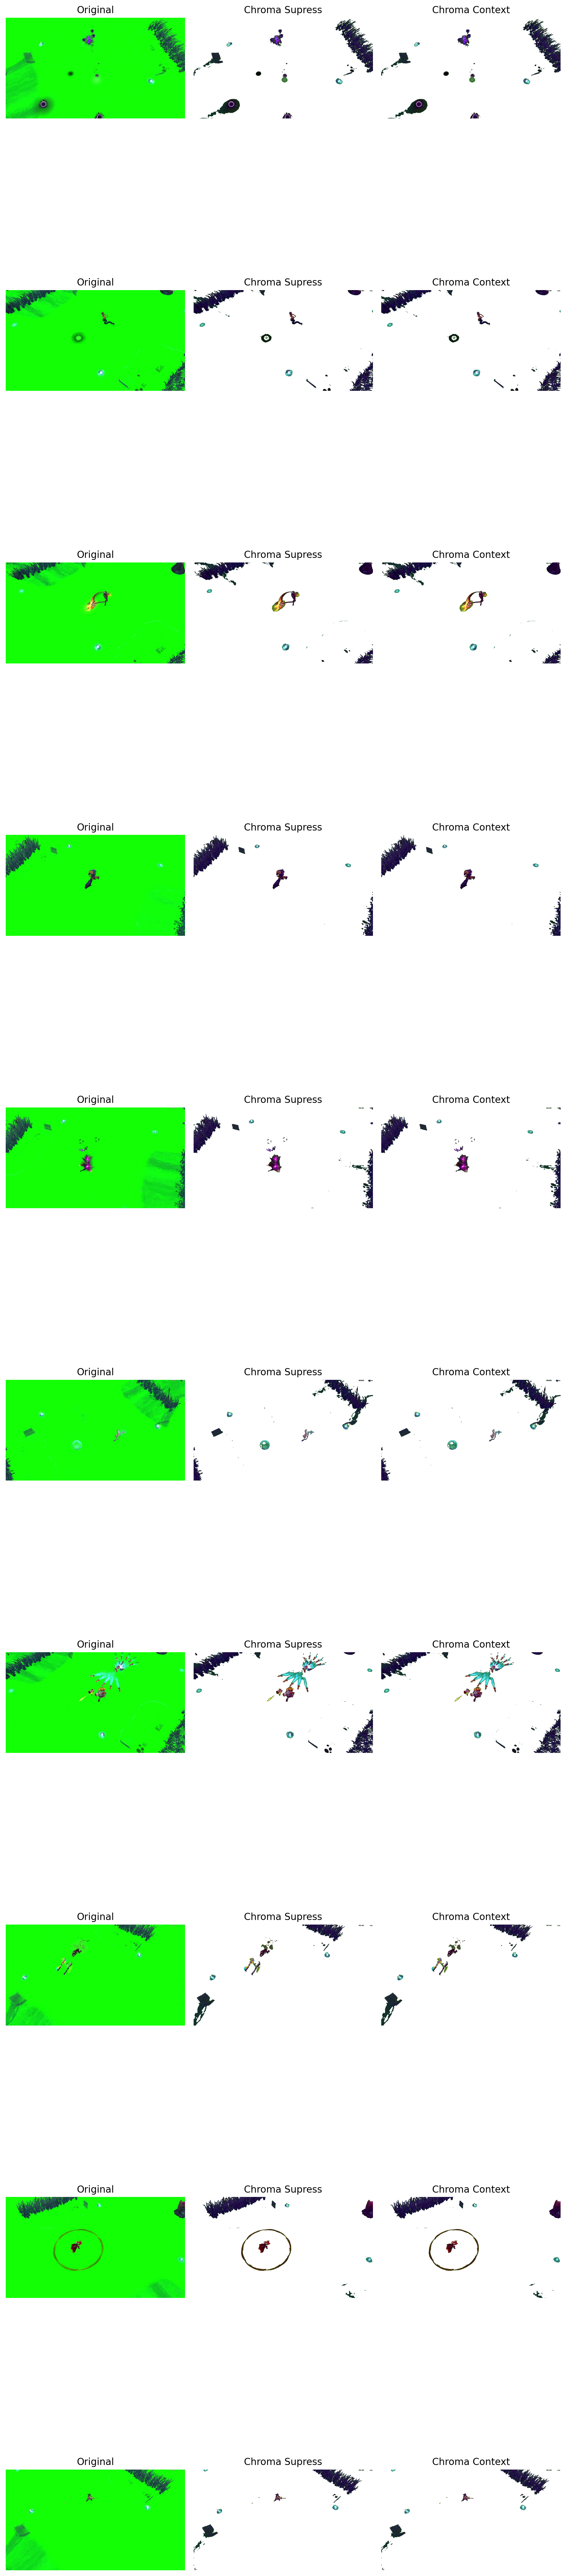

In [138]:
rows = len(sampled_imgs) 
 
fig, axes = plt.subplots(rows, ncols=3, figsize = (10, 5 * rows), dpi=200)
fig.subplots_adjust(hspace=0.01, wspace=0.1)

for i, (img_path, xml_path) in enumerate(zip(sampled_imgs, sampled_xmls)):
    boxes, labels = parse_pascal_voc_xml(xml_path)
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

    axes[i][0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i][0].axis('off')
    axes[i][0].set_title(f"Original")
    img_clean = clean_background_artifacts(img, green_bgr=(0, 255, 0), threshold=60)
    
    # masked = draw_matting(img_path)
    chroma = chroma_key_with_glow_preservation(img_clean)
    # chroma_suppress = suppress_only_lime(chroma, hue_range=(62, 73), sat_thresh=80, val_thresh=60, desat_strength=0.25)

    axes[i][1].imshow(cv2.cvtColor(chroma, cv2.COLOR_BGR2RGB))
    axes[i][1].axis('off')
    axes[i][1].set_title("Chroma Supress")
    
    alpha = alpha_from_green_distance(chroma)
    alpha = cv2.GaussianBlur(alpha, (5, 5), 0)  # soften transitions
    chroma_context = context_aware_despill(chroma, alpha=alpha)

    axes[i][2].imshow(cv2.cvtColor(chroma_context, cv2.COLOR_BGR2RGB))
    axes[i][2].axis('off')
    axes[i][2].set_title("Chroma Context")

plt.tight_layout()
plt.show()

### Champion/Ability Cutouts
- Assuming we have a working greenscreen cropping (which we don't but whatever)
- We use this algorithm to generate a cutout: 
- Get the bounding boxes of the champion and abilities used.
- Calculate IoU of champion with all ability bounding boxes
- Any ability box with IoU higher than 0.95 with champion is presumed to be for the champion itself and any lingering abilities - that will be used as the main champion cutout
    - Boundaries for that particular box can be determined by shrinking each side of the box until a non-white pixel is detected in a column/row
- Otherwise, the ability box is disjoint from the champion and can be placed anywhere UNLESS:
    - If any box is hugging the boundary of the image or close enough, it must be placed exactly on that part of the image, restricting where the cutout goes to that side of the image.



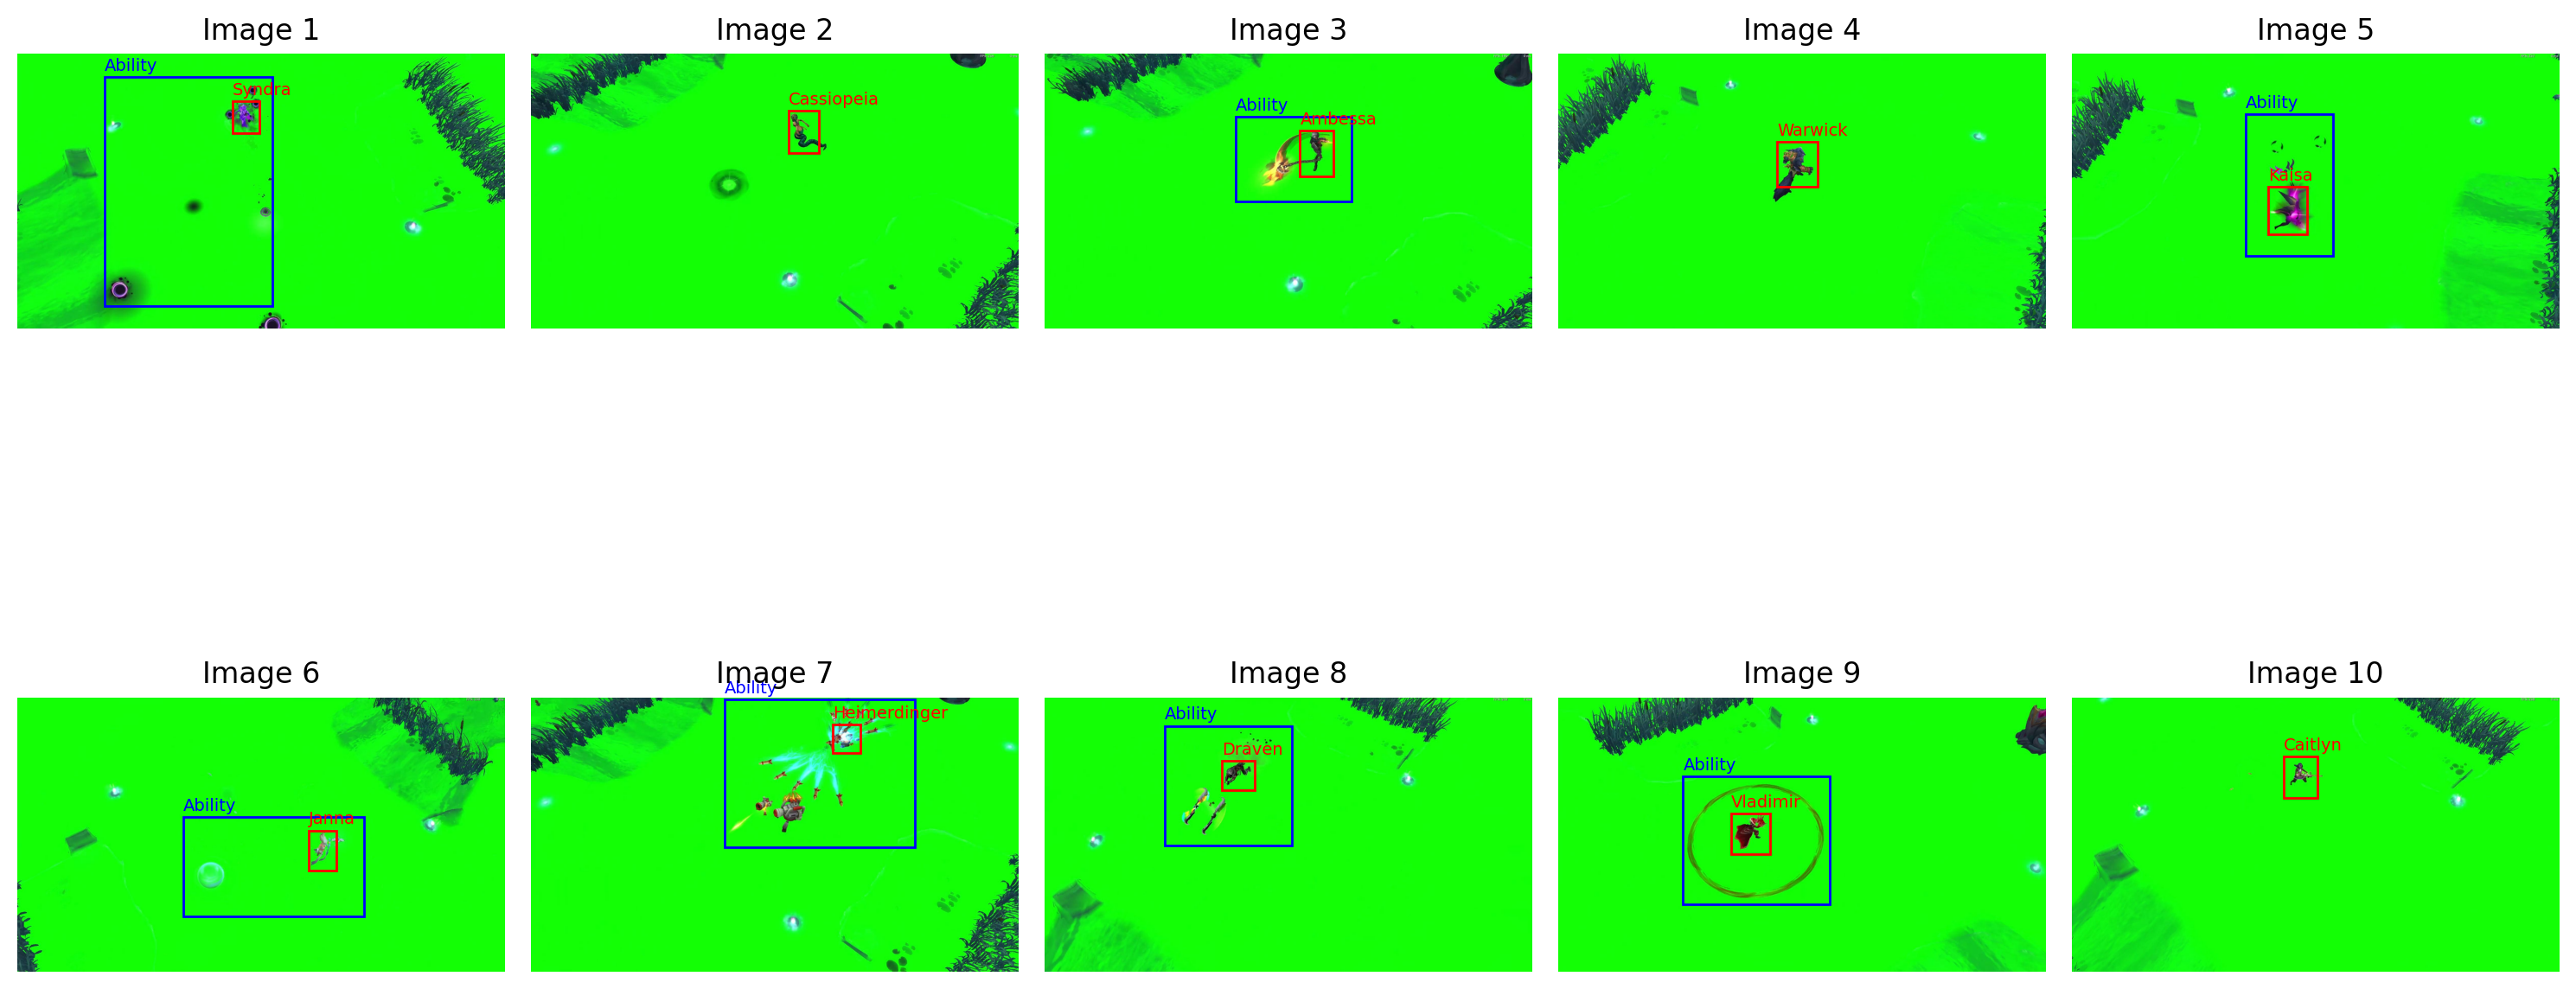

In [ ]:
def visualize_multiple_images_with_boxes(image_paths, xml_paths, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), dpi=200)
    fig.subplots_adjust(hspace=0.01, wspace=0.1)

    for i, (img_path, xml_path) in enumerate(zip(image_paths, xml_paths)):
        boxes, labels = parse_pascal_voc_xml(xml_path)
        img = cv2.imread(img_path)

        ax = axes[i // cols][i % cols]
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_title(f"Image {i + 1}")

        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            if label == champtoi['Ability']:
                color = 'blue'
            elif label == champtoi['Pet']:
                color = 'orange'
            else:
                color = 'red'
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                        fill=False, color=color, linewidth=1))
            ax.text(xmin, ymin - 25, str(itochamp[label]), color=color, fontsize=7)

    plt.tight_layout()
    plt.show()
visualize_multiple_images_with_boxes(sampled_imgs, sampled_xmls, rows=2, cols=5)

In [314]:
def generate_map_frames(video_path, dir_to_save, start_second, end_second, n = 5):
    """
    Generate frames from a video file and save them as images.
    
    :param video_path: Path to the input video file.
    :return: List of paths to the saved image frames.
    """
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    start_frame = int(start_second * fps)
    end_frame = int(end_second * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    frame_count = 0
    saved_frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Save every nth frame
        if start_frame + frame_count < end_frame:
            if frame_count % n == 0:
                frame_path = f"frame_{start_frame + frame_count}.jpg"
                cv2.imwrite(os.path.join(dir_to_save, frame_path), frame)
                saved_frames.append(frame_path)

        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()

generate_map_frames('/Users/HP/Documents/GitHub/JusticeGarenteed/frames/fullmap.mp4', '../frames/map', 7.8, 8.4, n = 5)

In [493]:
def chroma_key_with_glow_preservation(
    img_bgr,
    green_strength=0.9,
    despill_strength=0.75,
    blur_radius=5,
    erase_threshold=0.25,
    mask_color=(0, 0, 0),
    output_white_background=True,
    aggressive=False
):
    """
    Applies green screen removal while preserving semi-transparent glow/VFX.
    Aggressive mode uses tighter hue-based masking to avoid color bleed.

    Returns:
        np.ndarray: Output RGB image with green screen removed and background masked.
    """
    # Convert to float and normalize
    img = img_bgr.astype(np.float32) / 255.0

    if aggressive:
        # Convert to HSV
        hsv = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)

        # Define green hue range (lime green ~60–75)
        green_mask = (h >= 60) & (h <= 75) & (s > 80) & (v > 50)

        # Desaturate green hues to suppress them without hurting other colors
        s = np.where(green_mask, np.clip(s * (1 - despill_strength) * 0.5, 0, 255), s).astype(np.uint8)

        # Merge and convert back to BGR
        hsv_filtered = cv2.merge([h, s, v]).astype(np.uint8)
        img_bgr_filtered = cv2.cvtColor(hsv_filtered, cv2.COLOR_HSV2BGR)
        img = img_bgr_filtered.astype(np.float32) / 255.0

        # Estimate alpha based on green mask
        alpha = np.where(green_mask, 0.0, 1.0).astype(np.float32)
        alpha = cv2.GaussianBlur(alpha, (blur_radius, blur_radius), 0)

    else:
        # Original RGB-based green distance method
        green = np.array([0, 1, 0], dtype=np.float32)
        diff = np.linalg.norm(img - green, axis=2)
        alpha = np.clip(diff * green_strength, 0, 1)
        alpha = cv2.GaussianBlur(alpha, (blur_radius, blur_radius), 0)

        # Despill green
        alpha_exp = np.expand_dims(alpha, axis=-1)
        green_reduction = (1 - alpha_exp) * despill_strength
        img[..., 1] -= green_reduction[..., 0]
        img = np.clip(img, 0, 1)

    # Combine into RGBA
    rgba = np.dstack([img, alpha])
    rgba = (rgba * 255).astype(np.uint8)

    # Flatten by removing green haze with low alpha
    rgb = rgba[..., :3].astype(np.float32) / 255.0
    alpha_channel = rgba[..., 3:] / 255.0
    mask = alpha_channel > erase_threshold
    rgb *= mask
    flattened = (rgb * 255).astype(np.uint8)

    # Replace masked out areas with white or black
    mask_color_array = np.array(mask_color, dtype=np.uint8)
    mask = np.all(flattened <= mask_color_array, axis=-1)
    flattened[mask] = [255, 255, 255] if output_white_background else [0, 0, 0]

    if aggressive:
        # convert the already-flattened BGR → HSV
        hsv_flat = cv2.cvtColor(flattened, cv2.COLOR_BGR2HSV)
        h_flat = hsv_flat[...,0]
        # lime range ≈ 60–75°
        lime_mask = (h_flat >= 40) & (h_flat <= 65) & (s > 95) & (v > 95)
        # zero them out to background
        bg = [255,255,255] if output_white_background else [0,0,0]
        flattened[lime_mask] = bg

    return flattened


In [557]:
def IoU(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    
    :param box1: First bounding box [x_min, y_min, x_max, y_max].
    :param box2: Second bounding box [x_min, y_min, x_max, y_max].
    :return: IoU value.
    """
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    box1Area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2Area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    iou = interArea / float(box1Area + box2Area - interArea)
    return iou

def check_box_in_box(box1, box2):
    """
    Check if box1 is inside box2.
    
    :param box1: First bounding box [x_min, y_min, x_max, y_max].
    :param box2: Second bounding box [x_min, y_min, x_max, y_max].
    :return: True if box1 is inside box2, False otherwise.
    """
    return (box1[0] >= box2[0] and
            box1[1] >= box2[1] and
            box1[2] <= box2[2] and
            box1[3] <= box2[3])

def chroma_crop_out_white(img, box):
    """
   Crop the image using the bounding box, chroma key and then remove white areas.
    
    :param img: Input image.
    :return: Cropped image.
    """

    # shrink box to just hit edges (until there's no white)
    x_min, y_min, x_max, y_max = box
    cropped_img = img[y_min:y_max, x_min:x_max]
    cropped_img = chroma_key_with_glow_preservation(cropped_img, aggressive = True)
    mask = cv2.inRange(img, (0, 0, 0), (255, 255, 255))
    mask = cv2.bitwise_not(mask)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        # Update the bounding box
        x_min = x + x_min
        y_min = y + y_min
        x_max = x + x_min + w
        y_max = y + y_min + h
        box = [x_min, y_min, x_max, y_max]
        return cropped_img, box
    else:
        # No contours found, return the cropped image and box
        return cropped_img, box

def generate_cutout(img_path, xml_path):
    """
    Generate a cutout image from the original image and its corresponding XML file.
    
    :param img_path: Path to the input image file.
    :param xml_path: Path to the corresponding XML file.
    :return: Cutout image with green screen removed.
    """
    img = cv2.imread(img_path)
    boxes, labels = parse_pascal_voc_xml(xml_path)
    champion_box = None
    mask_box = None
    pet_boxes = []
    ability_boxes = set()
    label = 0

    box_dict = {'Ability' : [], 'Pet': [], 'Mask': []}

    for box, label in zip(boxes, labels):
        if label != champtoi['Ability'] and label != champtoi['Pet']:
            champion_box = box
            champion_label = label
        elif label == champtoi['Ability']:
            ability_boxes.add(tuple(box))
        else:
            pet_boxes.append(box)
    
    box_dict[itochamp[champion_label]] = []

    # Check if champion/pet box is inside ability box or significant overlap
    for box in ability_boxes:
        if check_box_in_box(champion_box, box) or IoU(champion_box, box) > 0.9:
            mask_box = box
        else:
            box_dict['Ability'].append(box)
    if mask_box is not None:
        ability_boxes.remove(mask_box)
    else:
        #Expand champion box by a factor of 2
        x_min, y_min, x_max, y_max = champion_box
        x_min = max(0, int(x_min - (x_max - x_min) * 0.85))
        y_min = max(0, int(y_min - (y_max - y_min) * 0.85))
        x_max = min(img.shape[1], int(x_max + (x_max - x_min) * 0.85))
        y_max = min(img.shape[0], int(y_max + (y_max - y_min) * 0.85))
        mask_box = [x_min, y_min, x_max, y_max]
        box_dict[itochamp[champion_label]].append(champion_box)
        box_dict['Mask'].append(mask_box)
        

    # Chroma key over mask box, crop out white areas
    cutout, mask_box = chroma_crop_out_white(img, mask_box)

    # If the champion is in the box, we need to return where the champion is relative to the box
    if mask_box is not None:
        x_min, y_min, x_max, y_max = mask_box
        x_min_champ, y_min_champ, x_max_champ, y_max_champ = champion_box
        x_min_champ = max(0, int(x_min_champ - x_min))
        y_min_champ = max(0, int(y_min_champ - y_min))
        
        x_max_champ = min(cutout.shape[1], int(x_max_champ - x_min))
        y_max_champ = min(cutout.shape[0], int(y_max_champ - y_min))
        champion_box = [x_min_champ, y_min_champ, x_max_champ, y_max_champ]
        box_dict["Mask"].append(list(mask_box))
    
    for pet_box in pet_boxes:
        if check_box_in_box(pet_box, mask_box) or IoU(pet_box, mask_box) > 0.9:
            x_min, y_min, x_max, y_max = mask_box
            x_min_pet, y_min_pet, x_max_pet, y_max_pet = pet_box
            x_min_pet = max(0, int(x_min_pet - x_min))
            y_min_pet = max(0, int(y_min_pet - y_min))
            x_max_pet = min(cutout.shape[1], int(x_max_pet - x_min))
            y_max_pet = min(cutout.shape[0], int(y_max_pet - y_min))
            box_dict['Pet'].append([x_min_pet, y_min_pet, x_max_pet, y_max_pet])
            
    box_dict[itochamp[champion_label]].append(champion_box)
    
    return cutout, box_dict 

def place_cutout(map_img, cutout, box_dict, x, y):
    """
    Place the cutout image on the map image at the specified coordinates,
    only pasting non-white pixels (to preserve transparency-like behavior).
    If the original mask box/champion box hugs a side of the image, the cutout can only be placed along that side.
    Abilities can be placed anywhere (even cut off the map) but champions and pets must be placed within the map bounds

    :param map_img: The map image (HWC, RGB) where the cutout will be placed.
    :param cutout: The cutout image to be placed (HWC, RGB).
    :param box_dict: Dictionary containing bounding boxes for champion, pet, and ability.
    :param x: X-coordinate for placement (top-left).
    :param y: Y-coordinate for placement (top-left).
    :return: Map image with the cutout placed.
    """
    mask_x_min, mask_y_min, mask_x_max, mask_y_max = box_dict['Mask'][0]

    # Check if cutout hugs side of image. If so, we can only place it along that side.
    if mask_x_min == 1 or mask_x_max == map_img.shape[1]:
        x = 0
    if mask_y_min == 1 or mask_y_max == map_img.shape[0]:
        y = 0


    # If placing the cutout makes the ability box go out of bounds, you can do so but up until the champion box hugging
    # the border of the image
    h, w = cutout.shape[:2]
    h = min(h, map_img.shape[0] - y)
    w = min(w, map_img.shape[1] - x)
    # Crop the region of interest from the map
    cutout = cutout[:h, :w]
    roi = map_img[y:y + h, x:x + w]

    # Create a mask for non-white pixels
    mask = ~(np.all(cutout == [255, 255, 255], axis=-1))

    # Broadcast mask to RGB
    mask_rgb = np.stack([mask]*3, axis=-1)    
    
    # Blend cutout into ROI using the mask
    roi[mask_rgb] = cutout[mask_rgb]

    # Put the modified ROI back
    map_img[y:y + h, x:x + w] = roi
    # Update the bounding boxes in box_dict to be relative to the map image
    for key in box_dict:
        if len(box_dict[key]):
            for box in box_dict[key]:
                x_min, y_min, x_max, y_max = box
                if key != 'Mask' and key != 'Ability':
                    # Just shift the champion/pet box
                    x_min = max(0, int(x_min + x))
                    y_min = max(0, int(y_min + y))
                    x_max = int(x_max + x)
                    y_max = int(y_max + y)
                    if x_max > map_img.shape[1] or y_max > map_img.shape[0]:
                        raise ValueError(f"Box {key} goes out of bounds: {box}")
                    box_dict[key] = [x_min, y_min, x_max, y_max]
                else: 
                    x_diff = box[0] - x
                    y_diff = box[1] - y
                    x_min = max(0, int(x_min - x_diff))
                    y_min = max(0, int(y_min - y_diff))
                    x_max = min(map_img.shape[1], int(x_max - x_diff))
                    y_max = min(map_img.shape[0], int(y_max - y_diff))
                    box_dict[key] = [x_min, y_min, x_max, y_max]
    
    return map_img, box_dict


In [334]:
def get_boxes_from_box_dict(box_dict):
    """
    Convert the box_dict to a list of boxes for each category.
    
    :param box_dict: Dictionary containing bounding boxes for champion, pet, and ability.
    :return: List of boxes for each category.
    """
    boxes = []
    labels = []
    for key in box_dict:
        if len(box_dict[key]):
            boxes.append(box_dict[key])
            if key == 'Mask':
                labels.append(champtoi['Ability'])
            else:
                labels.append(champtoi[key])
    return boxes, labels

In [364]:
def plot_image_with_boxes(img, boxes, labels):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10), dpi = 300)
    plt.imshow(img_rgb)
    
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=1))
        plt.text(xmin, ymin -25, str(itochamp[label]), color='red', fontsize=7)

    plt.axis('off')
    plt.show()

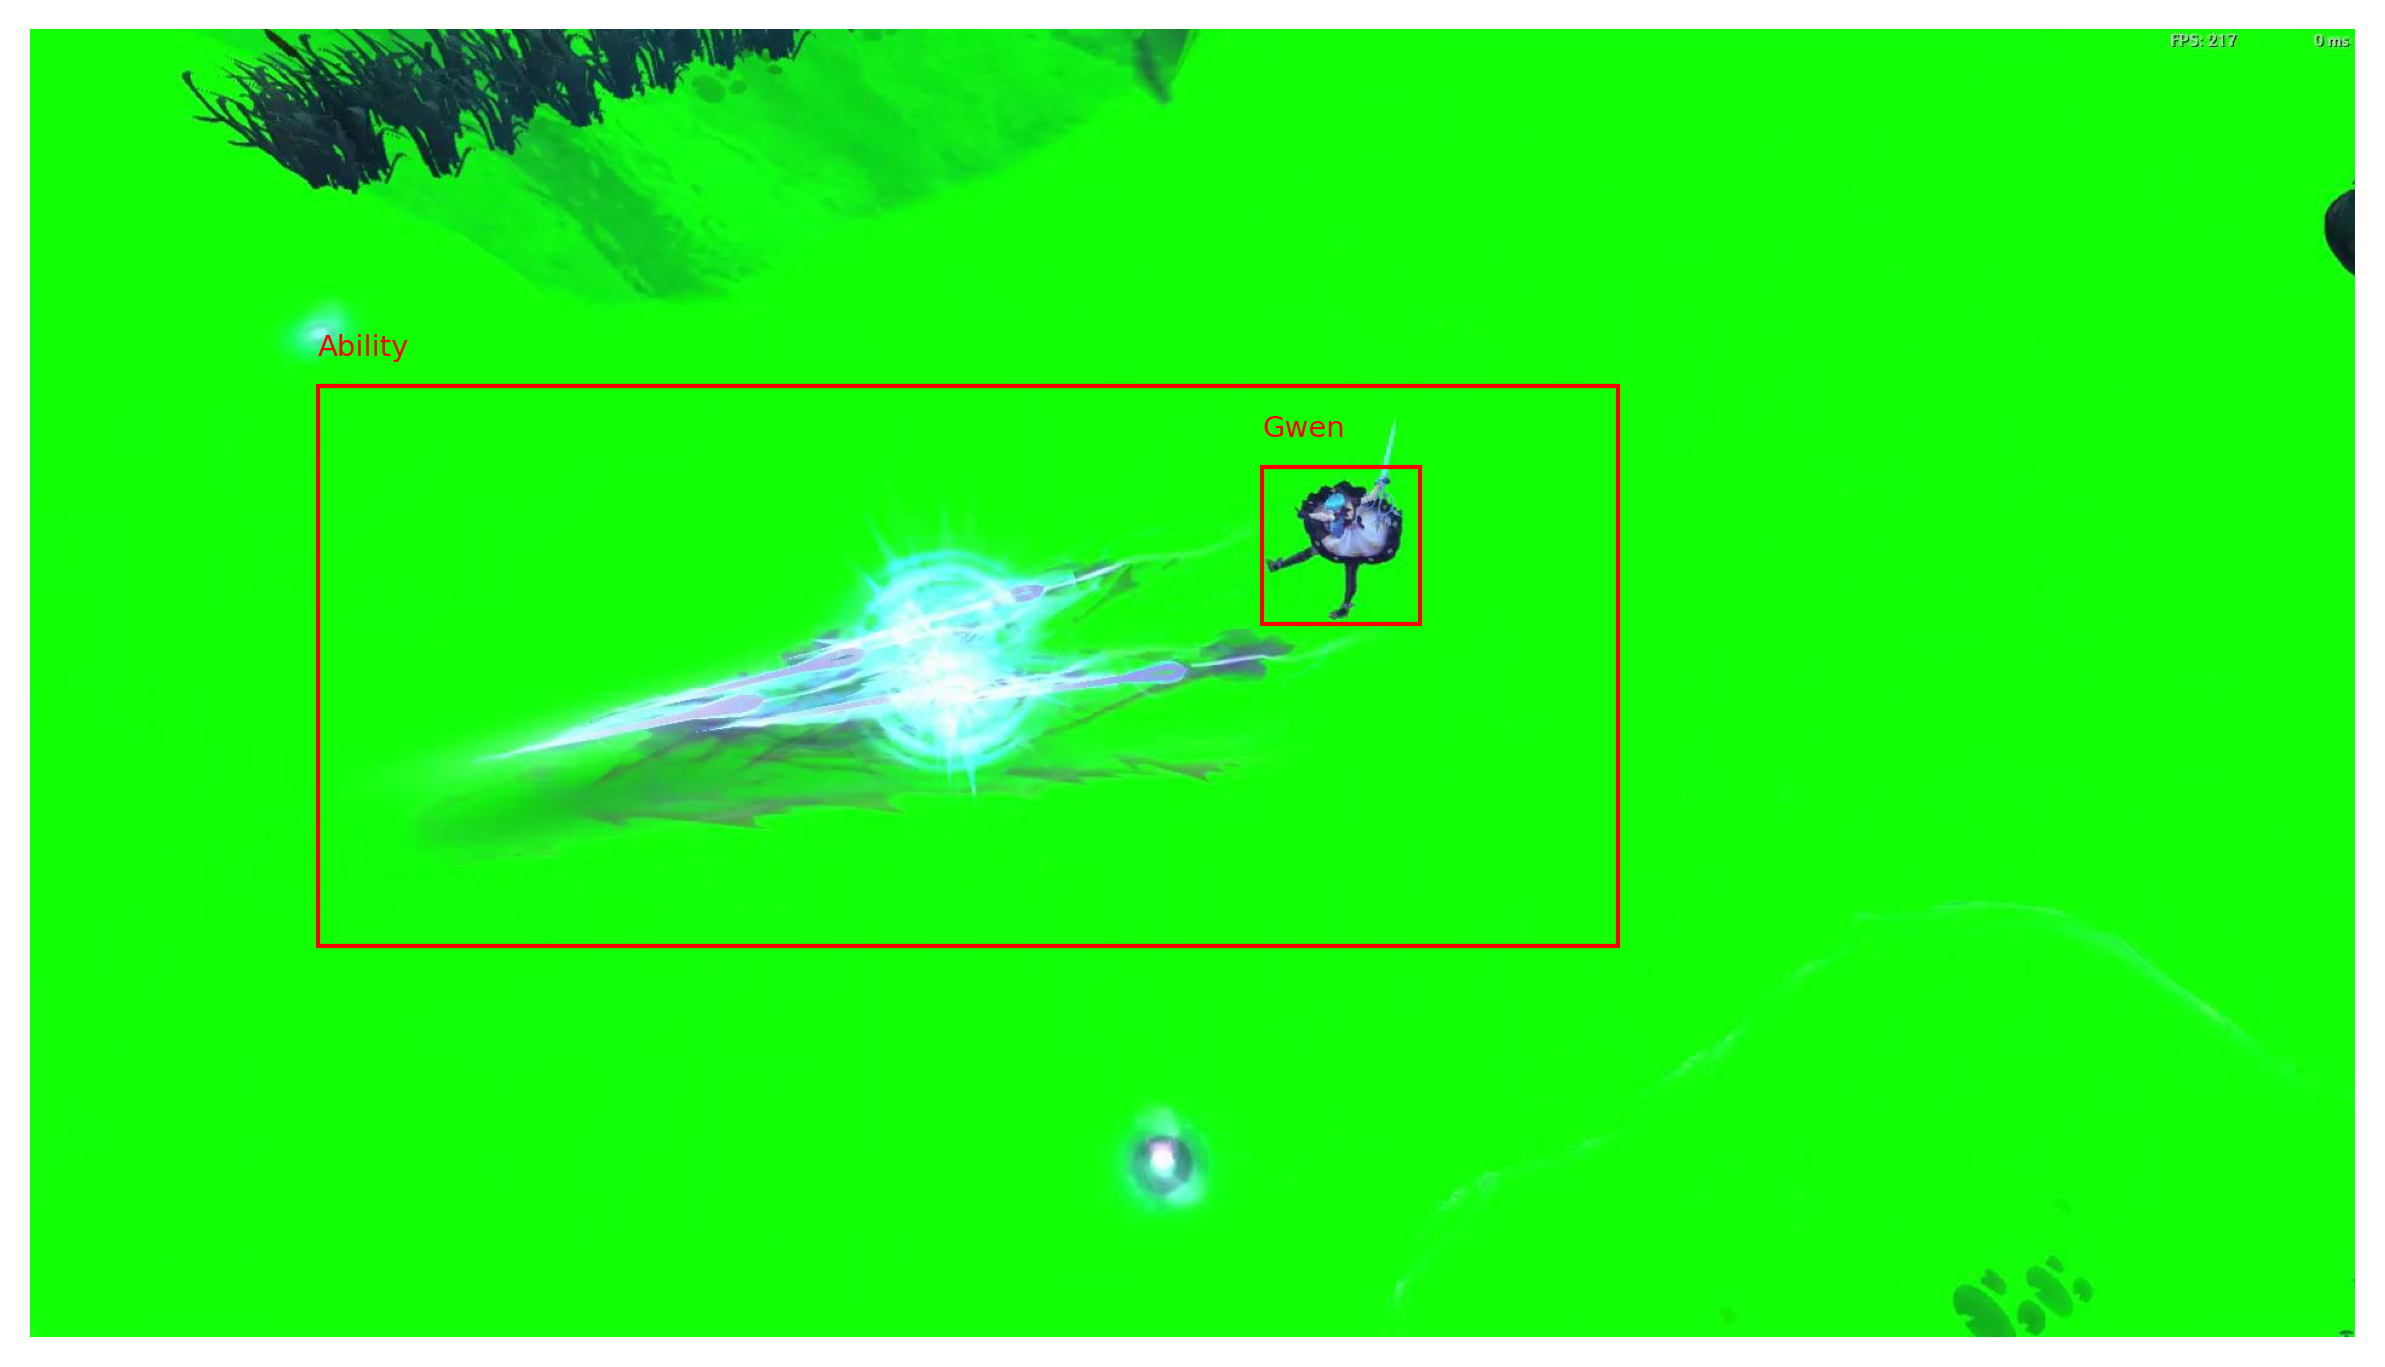

{'Ability': [], 'Pet': [], 'Mask': [[237, 294, 1311, 757]], 'Gwen': [[780, 67, 910, 197]]}


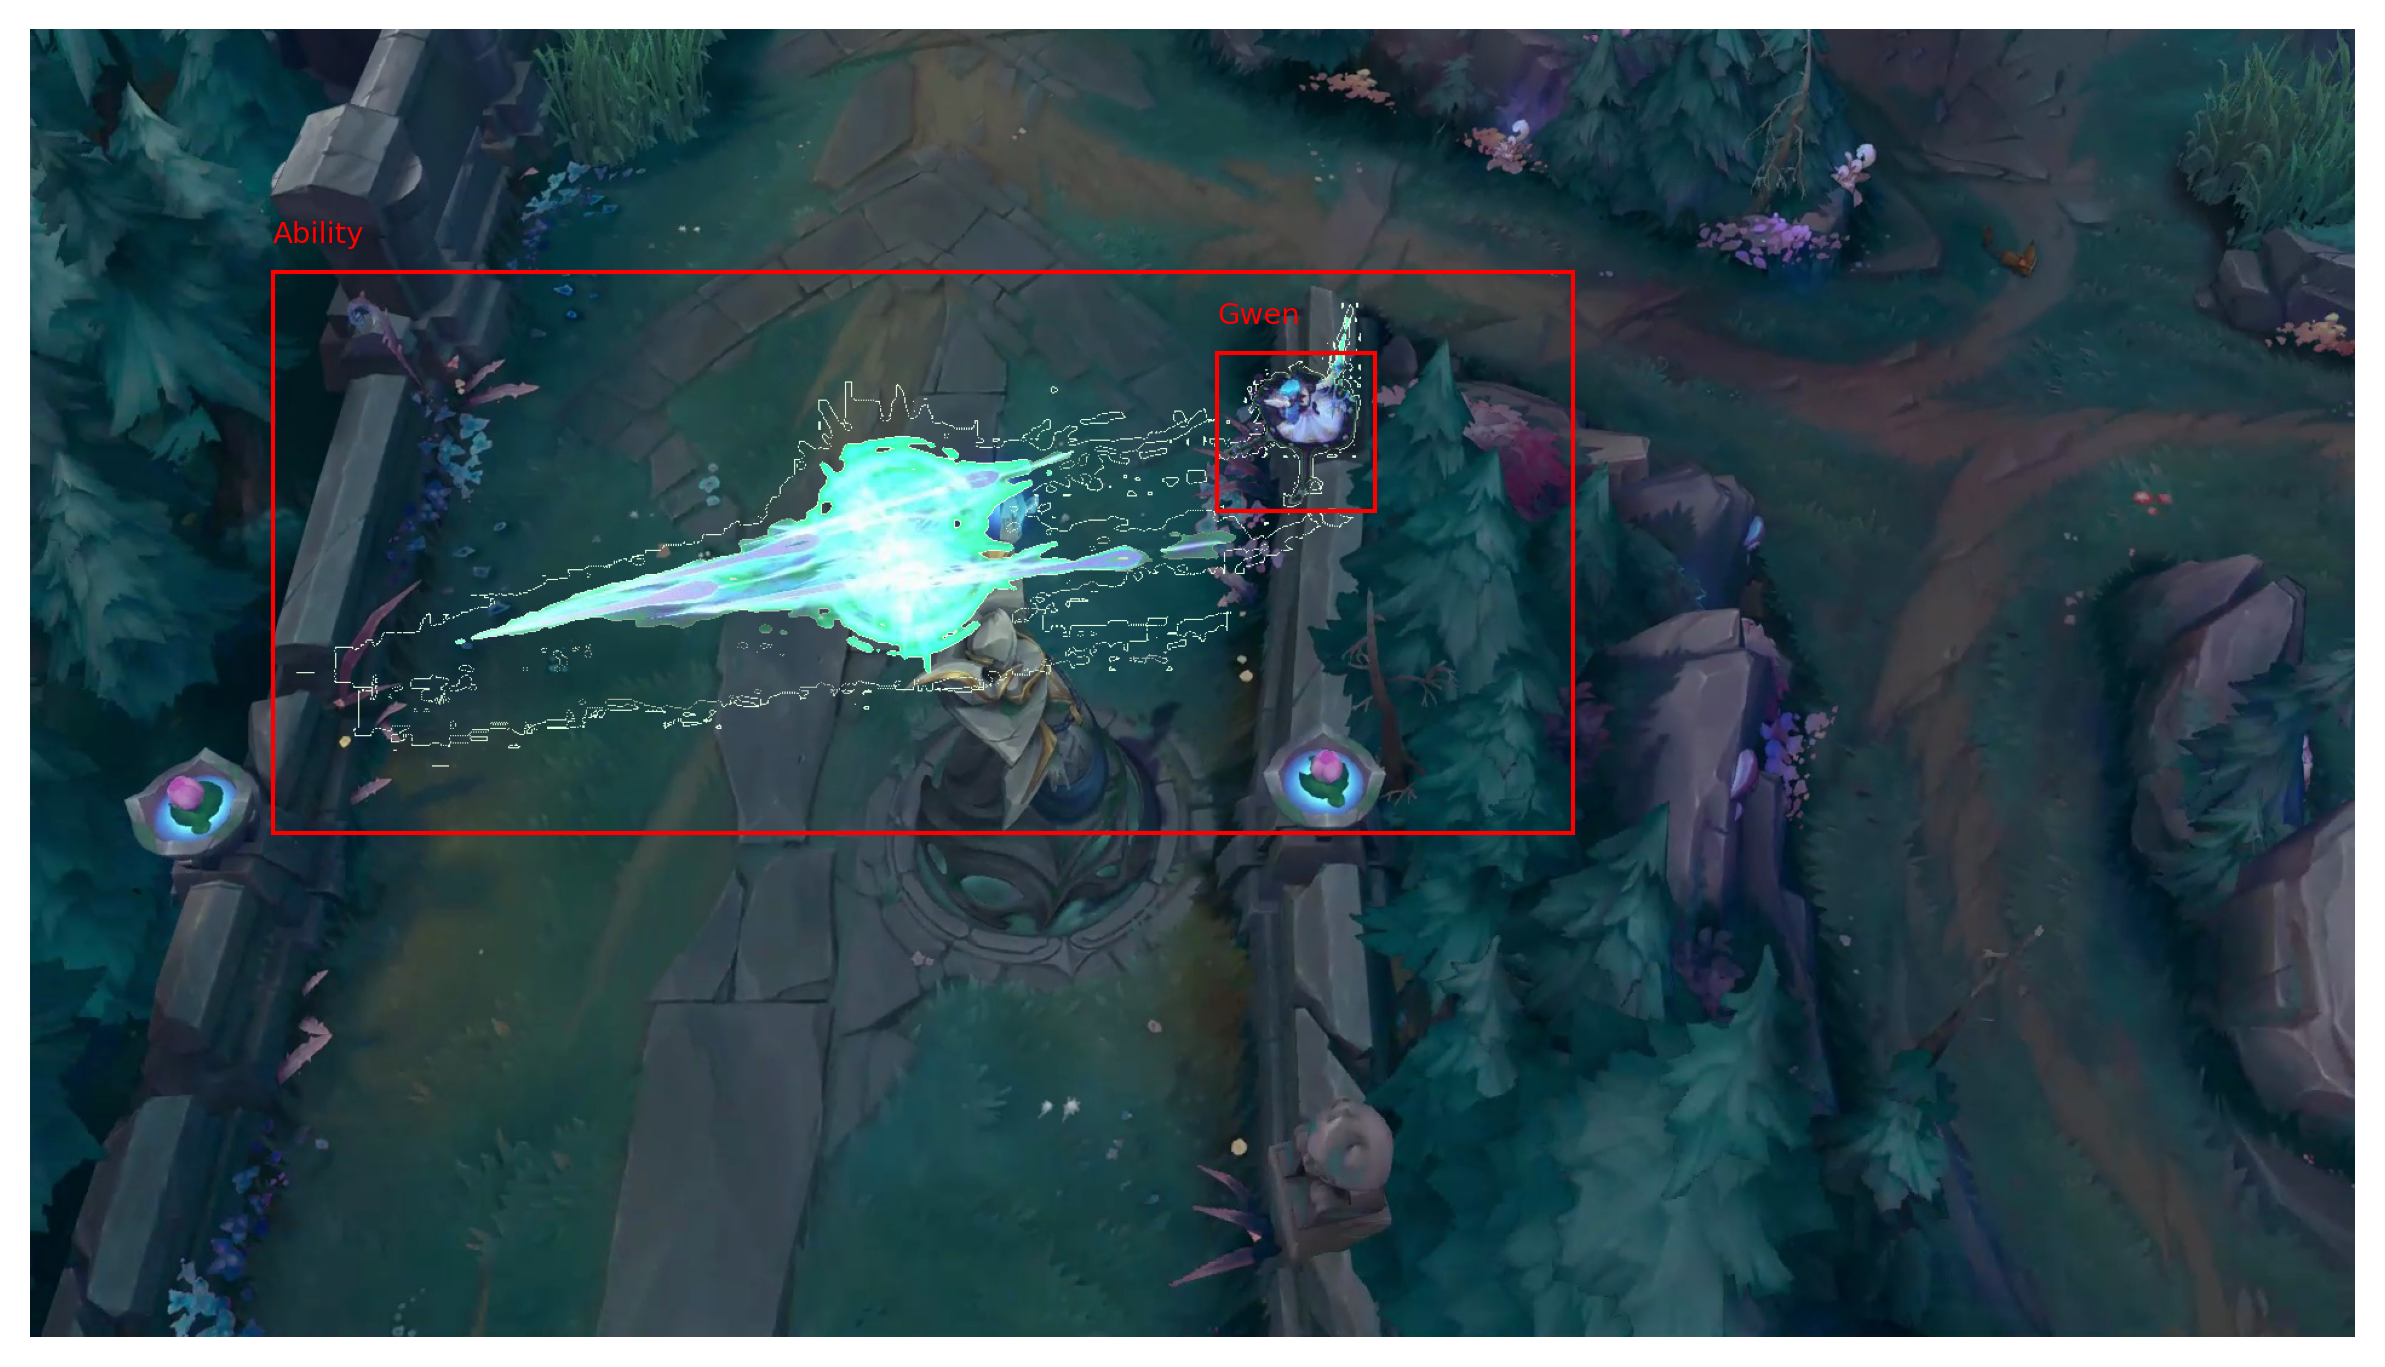

In [558]:
index = random.sample(range(len(imgs)), 1)
# test_img_path = os.path.join('../greenscreends/train/', imgs[index[0]])
# test_xml = os.path.join('../greenscreends/train/', xmls[index[0]])
# print(test_img_path)
test_img_path = "/Users/HP/Documents/GitHub/JusticeGarenteed/greenscreends/train/gwen_train_00014_png.rf.e16b9da610970fa258c1633b17b5cf65.jpg"
test_xml = "/Users/HP/Documents/GitHub/JusticeGarenteed/greenscreends/train/gwen_train_00014_png.rf.e16b9da610970fa258c1633b17b5cf65.xml"
map_img = "../frames/map/frame_270.jpg"
test_img = cv2.imread(test_img_path)
boxes, labels = parse_pascal_voc_xml(test_xml)
img = cv2.imread(test_img_path)
plot_image_with_boxes(img, boxes, labels)
cutout, box_dict = generate_cutout(test_img_path, test_xml)
map_img = cv2.imread(map_img)
print(box_dict)
map_img, box_dict = place_cutout(map_img, cutout, box_dict, 200, 200)
boxes, labels = get_boxes_from_box_dict(box_dict)
plot_image_with_boxes(map_img, boxes, labels)